In [138]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train/'
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'
TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

In [139]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

plt.rcParams['figure.dpi'] = 100

In [140]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

In [141]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet50.a1_in1k"
    epochs = 50
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 64
    # gradient_accumulation_steps = 1

    lr = 5e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 500

In [142]:
device = torch.device(CFG.device)

In [143]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv'))
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [144]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)].reset_index(drop=True)
train_data = train_data.groupby('level').head(CFG.samples_per_class).reset_index(drop=True)
len(train_data)

2420

In [145]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [146]:
transform = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [147]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

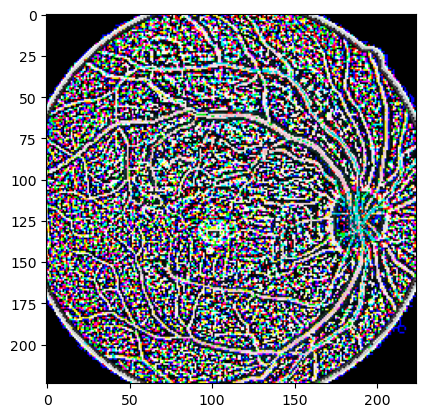

In [148]:
# visualize the transformations
train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, transform)
image, label = train_dataset[15]
transformed_img_pil = func.to_pil_image(image)
plt.imshow(transformed_img_pil)

##### Note that the severity levels in test / query images are 0, 1, 2, 3 ie only 4 levels.
##### However the severity levels in train images are 0, 1, 2, 3, 4 ie 5 levels.

In [149]:
os.listdir(TEST_DATA_FOLDER )

['DR2', 'Normal', 'DR3', 'DR1']

In [150]:
# load model
model = timm.create_model(CFG.model_name, num_classes=5, checkpoint_path=OUTPUT_FOLDER + 'best_model.pth')
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=CFG.workers)
model.eval()
model = model.to(device)

In [151]:
def convert_level(level):
    """
    converts training level to  query level
    """
    if level == 0:
        return 0
    else:
        return level * 3 / 4

## Retrieving Nearest Neighbours and Selecting Label Accordingly

In [152]:
k = 5

In [153]:
from sklearn.neighbors import NearestNeighbors

def get_all_embeddings(dataloader, model):
    with torch.no_grad():
        embeddings = []
        for image, _ in dataloader:
            image = image.to(device)
            output = model(image)       
            embeddings.append(output.cpu().numpy())
        
    return np.vstack(embeddings)


def get_nearest_images(query_img, dataloader, model, k=k):
    # Get embeddings for all images
    all_embeddings = get_all_embeddings(dataloader, model)

    # Query image (assuming it is loaded and transformed similarly)
    query_image = transform(query_img).unsqueeze(0).to(device)  # Unsqueeze to add the batch dimension
    query_embedding = model(query_image).detach().cpu().numpy()

    # Find the k nearest images
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(all_embeddings)
    distances, indices = nbrs.kneighbors(query_embedding)

    # Resulting indices are the indices of the closest images in your dataset
    print(f"Indices of {k} nearest images:", indices[0])
    print("Levels of nearest images [0 - 4]:", [train_data.loc[idx].level for idx in indices[0]])
    print("Levels in query form [0 - 3]:", [convert_level(train_data.loc[idx].level) for idx in indices[0]])
    print("Distances:", distances[0])
    print("Mean distance:", np.mean(distances))
    print("Median distance:", np.median(distances))

    print ("----------------------------------------")
    print(f"Predicted Level [from 0 to 3]: {np.mean([convert_level(train_data.loc[idx].level) for idx in indices[0]]): .1f}")
    
    return indices

In [154]:
# taking a random image from the DR 2 class
query_img = Image.open(TEST_DATA_FOLDER + '/DR2/1ffa93c6-8d87-11e8-9daf-6045cb817f5b..JPG')
indices = get_nearest_images(query_img, dataloader, model)

Indices of 5 nearest images: [ 696 1643  945 1255 1770]
Levels of nearest images [0 - 4]: [2, 3, 3, 2, 1]
Levels in query form [0 - 3]: [1.5, 2.25, 2.25, 1.5, 0.75]
Distances: [0.67072213 1.09401074 1.7049605  1.7087235  1.78608376]
Mean distance: 1.3929001263662188
Median distance: 1.7049604965151375
----------------------------------------
Predicted Level [from 0 to 3]:  1.6


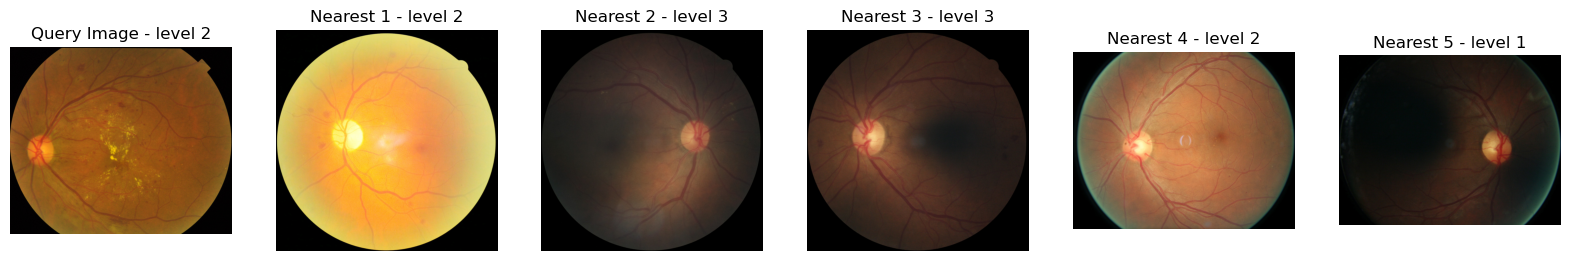

In [155]:
# show the nearest images
fig, axs = plt.subplots(1, k+1, figsize=(20, 8))

# query image
axs[0].imshow(query_img)
axs[0].axis('off')
axs[0].set_title("Query Image - level 2")

for i, idx in enumerate(indices[0]):
    img = Image.open(TRAIN_DATA_FOLDER + train_data.loc[idx].image + ".jpeg")
    axs[i+1].imshow(img)
    axs[i+1].axis('off')
    axs[i+1].set_title(f"Nearest {i+1} - level {train_data.loc[idx].level}")

## Disease Severity Order on a Continuous Spectrum

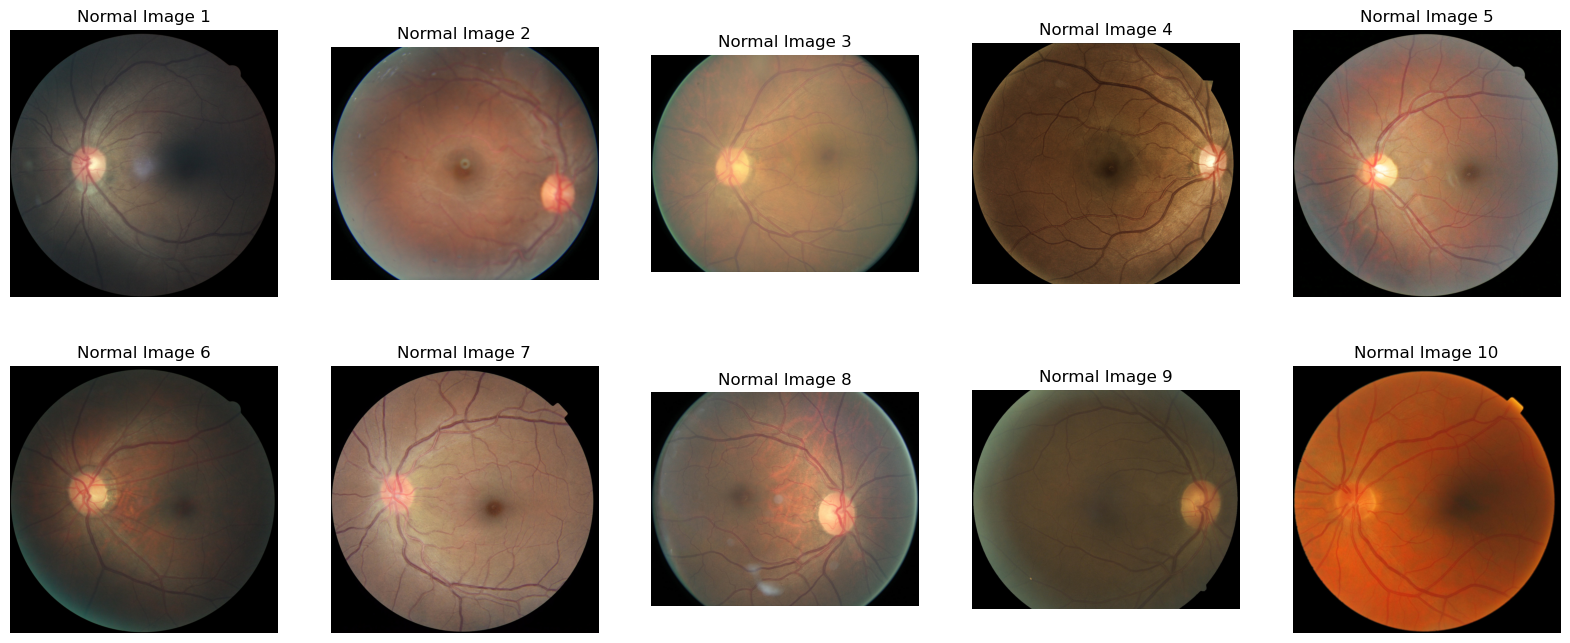

In [172]:
# randomly sample 10 images from the train data folder

normal_images = list(train_data[train_data.level == 0].sample(10).image)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

axs = axs.ravel()

for i, img_name in enumerate(normal_images):
    img = Image.open(TRAIN_DATA_FOLDER + img_name + ".jpeg")
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Normal Image {i+1}")

In [173]:
def get_embeddings(img, model):
    img = transform(img).unsqueeze(0).to(device)
    output = model(img)
    return output

def get_severity_order(query_img, model, base_images):
    # median euclidean distance of the query image from the base images
    
    # Get embeddings for the query image and base images in a single batch
    query_embedding = get_embeddings(query_img, model)
    base_embeddings = torch.cat([get_embeddings(Image.open(TRAIN_DATA_FOLDER + img_name + ".jpeg"), model)
                                   for img_name in base_images])

    # Calculate pairwise distances using vectorized operations
    distances = torch.norm(query_embedding - base_embeddings, dim=1)

    # Get the median distance
    severity = torch.median(distances).item()

    return severity

In [174]:
severity = get_severity_order(query_img, model, normal_images)
print(f'Order of severity of the disease: {severity:.2f}')

Order of severity of the disease: 10.79


#### Note that this severity order is totally different from the levels we had in the dataset.

In [175]:
# finding severity for all test images
severities = {'0': [], '1': [], '2': [], '3': []}

rel = {'0': 'Normal/', '1': 'DR1/', '2': 'DR2/', '3': 'DR3/'}

for level in rel:
    for img_name in os.listdir(TEST_DATA_FOLDER + rel[level]):
        img = Image.open(TEST_DATA_FOLDER + rel[level] + img_name)
        severity = get_severity_order(img, model, normal_images)
        severities[level].append(severity)


/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Severity Order vs Level')

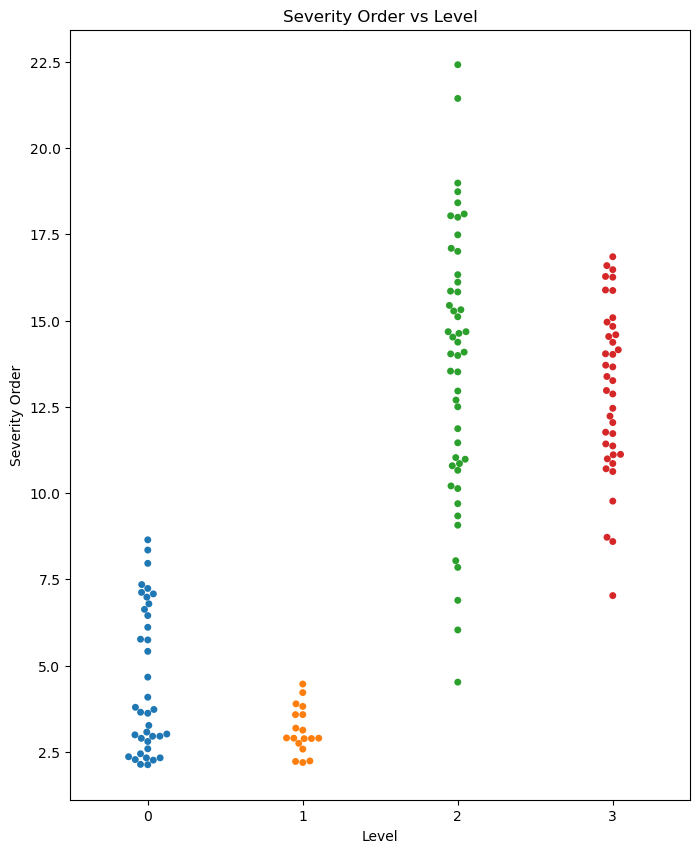

In [176]:
# make a box plot for level vs predicted severity order
fig = plt.figure(figsize=(8, 10))
sns.swarmplot(data=[severities['0'], severities['1'], severities['2'], severities['3']])
plt.xlabel('Level')
plt.ylabel('Severity Order')
plt.title('Severity Order vs Level')

In [177]:
plt.savefig(OUTPUT_FOLDER + 'severity_order.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>